In [1]:
from ImpactAtmosphere import SteamAtm
from ImpactAtmosphere import EvolveAtm as ev
from clima import WaterAdiabatClimate
from photochem import EvoAtmosphere, zahnle_earth, io

import numpy as np
from matplotlib import pyplot as plt

from threadpoolctl import threadpool_limits
threadpool_limits(limits=1);

import impact_simulations as imp

In [2]:
params = imp.Ceres_nominal()

In [11]:
init = params['init']
N_H2O_ocean = init['N_H2O_ocean']
N_CO2 = init['N_CO2']
N_N2  = init['N_N2']
M_i = init['M_i']
stm = SteamAtm('zahnle_earth_ct.yaml')
sol_stm = stm.impact(N_H2O_ocean,N_CO2,N_N2,M_i)

# 0-D model
init_atm = stm.init_for_integrate(sol_stm)
sol_atm = ev.integrate(init_atm,rtol=1e-9)

yr = 365*24*60*60
ind = np.argmin(np.abs(sol_atm['H2']*sol_atm['Ntot']/(sol_atm['H2'][0]*sol_atm['Ntot'][0]) - 0.8))
print("timescale of hydrogen escape =",'%.2f'%(sol_atm['time'][ind]/yr/1e6),'Myrs')

Integration successful.                 
timescale of hydrogen escape = 0.35 Myrs


In [20]:

pc = EvoAtmosphere(zahnle_earth,\
                params['outfile']+"_settings.yaml",\
                "input/Sun_4.0Ga.txt",\
                params['outfile']+"_atmosphere.txt")

In [6]:
sol1 = io.evo_read_evolve_output(params['outfile']+".dat")
sol_pc = io.reformat_output_dict(sol1)

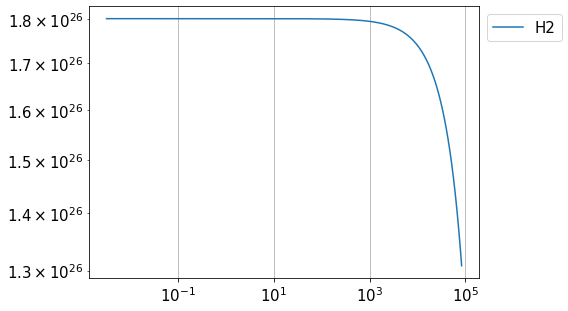

In [42]:
sol1 = io.evo_read_evolve_output(params['outfile']+".dat")
sol_pc = io.reformat_output_dict(sol1)


plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])

yr = 365*24*60*60
species = ['H2']
for sp in species:
    SP = np.zeros(len(sol_pc['time']))
    for i in range(len(sol_pc['time'])):
        dz = (sol1['alt'][1,i]-sol1['alt'][0,i])*1e5
        SP[i] = np.sum(sol_pc[sp][:,i])*dz
    ax.plot(sol_pc['time']/yr,SP,'-',label=sp)

ax.grid()
ax.legend(ncol=2,bbox_to_anchor=(1,1.0),loc='upper left')
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim(1e7,5e13)
# ax.set_ylim(1e15,6e25)

plt.show()

In [27]:
sol1 = io.evo_read_evolve_output(params['outfile']+".dat")
sol_pc = io.reformat_output_dict(sol1

T_surf = np.empty(len(sol1['time']))
for i in range(len(T_surf)):
    pc.regrid_prep_atmosphere(sol1['usol'][:,:,i],sol1['top_atmos'][i])
    T_surf[i] = pc.T_surf
    print(i,end='\r')

In [41]:
time = 2
j = np.argmin(np.abs(sol_pc['time']/yr-time))
print(sol_pc['time'][j]/yr,sol1['top_atmos'][j])

time = 1
j = np.argmin(np.abs(sol_pc['time']/yr-time))
print(sol_pc['time'][j]/yr,sol1['top_atmos'][j])

1.9926867211841348 84253416.75019765
0.9882528453889096 85972874.23489556


In [37]:
sol1['top_atmos'][j]

84253416.75019765

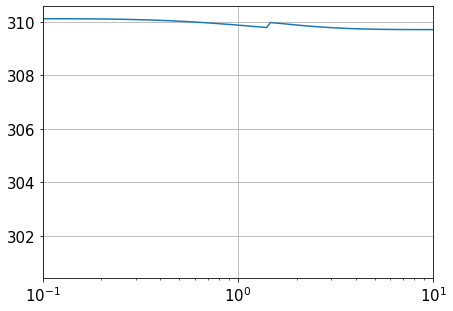

In [34]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])

yr = 365*24*60*60
ax.plot(sol_pc['time']/yr,T_surf,'-')

ax.grid()
# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(.1,1e1)
# ax.set_ylim(300,312)

plt.show()

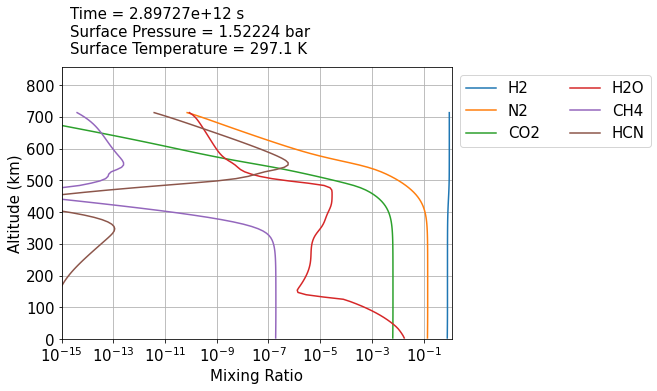

In [54]:
sol1 = io.evo_read_evolve_output(params['outfile']+".dat")
sol_pc = io.reformat_output_dict(sol1)

plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])

yr = 365*24*30*30


species = ['H2','N2','CO2','H2O','CH4','HCN']
# species = sol1['species_names']

i = -1
den = np.sum(sol1['usol'][:,:,i],axis=0)
pc.regrid_prep_atmosphere(sol1['usol'][:,:,i],sol1['top_atmos'][i])
for sp in species:
    ax.plot(sol_pc[sp][:,i]/den,sol_pc['alt'][:,i],label=sp)


ax.grid()
ax.legend(ncol=2,bbox_to_anchor=(1,1.0),loc='upper left')
ax.set_xscale('log')
ax.set_xlim(1e-15,1.3)
ax.set_ylim(0,856)
message = 'Time = '+'%.5e'%(sol_pc['time'][i])+' s' \
          +'\nSurface Pressure = '+'%.5f'%pc.var.surface_pressure+' bar' \
          +'\nSurface Temperature = '+'%.1f'%pc.T_surf+' K'
ax.text(0.02, 1.04, message, \
            size = 15,ha='left', va='bottom',transform=ax.transAxes)
ax.set_ylabel('Altitude (km)')
ax.set_xlabel('Mixing Ratio')

plt.show()

1.4253168551258326

In [47]:
pc.var.surface_pressure

1.5405473682615918

In [2]:
N_H2O_ocean = 15.0e3
N_CO2 = 23.*0.1
N_N2  = 36.
M_i = 2e24
stm = SteamAtm('zahnle_earth_ct.yaml')
sol_stm = stm.impact(N_H2O_ocean,N_CO2,N_N2,M_i)

Integration successful.                 


In [3]:
c = WaterAdiabatClimate('input/adiabat_species.yaml', \
                        'input/adiabat_settings.yaml', \
                        'input/Sun_4.0Ga.txt')

In [15]:
N_i = np.empty(len(c.species_names))
for i,sp in enumerate(c.species_names):
    N_i[i] = sol_stm[sp][-1]*sol_stm['Ntot'][-1]

In [19]:
c.RH = 0.7
T_guess = 430
T = c.surface_temperature_column(N_i, T_guess=T_guess)
c.to_regular_grid()

In [ ]:
c.out2atmosphere.txt()

In [50]:
from photochem.utils._format import FormatSettings_main, yaml, MyDumper, Loader

def make_atmosphere_txt(c, sol, atmosphere_out, eddy, RH, P_top, T_trop, T_guess, zero_out):
    N_i = np.empty(len(c.species_names))
    for i,sp in enumerate(c.species_names):
        if sp in zero_out:
            N_i[i] = 1.0e-20
        else:
            N_i[i] = sol[sp][-1]*sol['Ntot'][-1]
    c.RH = RH
    c.P_top = P_top
    c.T_trop = c.T_trop
    T = c.surface_temperature_column(N_i, T_guess=T_guess) 
    eddy_ = np.ones(len(c.z))*eddy 
    c.out2atmosphere_txt(atmosphere_out, eddy_)    

def make_settings(infile, outfile, ztop, nz, RH, rainfall_rate, trop_alt):

    fil = open(infile,'r')
    data = yaml.load(fil,Loader=Loader)
    fil.close()

    data['atmosphere-grid']['bottom'] = 0.0
    data['atmosphere-grid']['top'] = float(ztop)
    data['atmosphere-grid']['number-of-layers'] = int(nz)
    
    data['planet']['water']['relative-humidity'] = float(RH)
    
    if rainfall_rate > 0:
        data['planet']['water']['gas-rainout'] = True
        data['planet']['water']['rainfall-rate'] = float(rainfall_rate)
        data['planet']['water']['tropopause-altitude'] = float(trop_alt)
    else:
        data['planet']['water']['gas-rainout'] = False    
    
    data = FormatSettings_main(data)

    fil = open(outfile,'w')
    yaml.dump(data,fil,Dumper=MyDumper,sort_keys=False,width=70)
    fil.close()
    
def couple2photochem(c, sol, settings_in, settings_out, atmosphere_out, \
                     eddy, RH, P_top, T_trop, T_guess, zero_out, nz, rainfall_rate):
    make_atmosphere_txt(c, sol, atmosphere_out, eddy, RH, P_top, T_trop, T_guess, zero_out)
    
    ind = (c.T-c.T_trop==0).argmax()
    trop_alt = c.z[ind]
    
    ztop = c.z[-1]+0.5*c.dz[-1]
    
    make_settings(settings_in, settings_out, ztop, nz, RH, rainfall_rate, trop_alt)


In [52]:
settings_in = "input/settings_Hadean.yaml"
settings_out = "settings_test.yaml"
atmosphere_out = 'atmosphere.txt'
eddy = 1.0e6
RH = 1
P_top = 1e-4
T_trop = 200
T_guess = 400
zero_out = ['NH3']
nz = 100
rainfall_rate = 1

couple2photochem(c, sol_stm, settings_in, settings_out, atmosphere_out, \
                 eddy, RH, P_top, T_trop, T_guess, zero_out, nz, rainfall_rate)

In [54]:
pc = EvoAtmosphere(zahnle_earth, \
                  settings_out, \
                  'input/Sun_4.0Ga.txt', \
                  atmosphere_out)

In [60]:
pc.var.surface_pressure

19.346856254136778

In [76]:
np.sum(c.densities[:,c.species_names.index('H2O')]*c.dz)

4.78517525601787e+26

In [77]:
dz = pc.var.z[1] - pc.var.z[0]
ind = pc.dat.species_names.index('H2O')
np.sum(pc.wrk.usol[ind,:]*dz)

4.785175256017869e+26

In [ ]:
ind = (c.T-c.T_trop==0).argmax()
trop_alt = c.z[ind]

In [46]:
def couple2photochem(c, sol, settings_in, settings_out, atmosphere_out, \
                     eddy, RH, P_top, T_trop, T_guess, zero_out, nz, rainfall_rate):
    make_atmosphere_txt(c, sol, atmosphere_out, eddy, RH, P_top, T_trop, T_guess, zero_out)
    
    ind = (c.T-c.T_trop==0).argmax()
    trop_alt = c.z[ind]
    
    ztop = c.z[-1]+0.5*c.dz[-1]
    
    make_settings(settings_in, settings_out, ztop, nz, rainfall_rate, trop_alt)
    
    
    

616.4749369639746

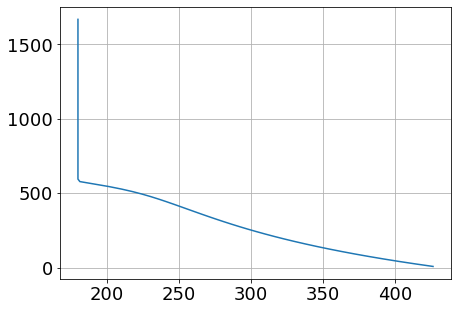

In [20]:
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(1,1,figsize=[7,5])
fig.patch.set_facecolor("w")
ax.plot(c.T,c.z/1e5)
ax.grid()
plt.show()

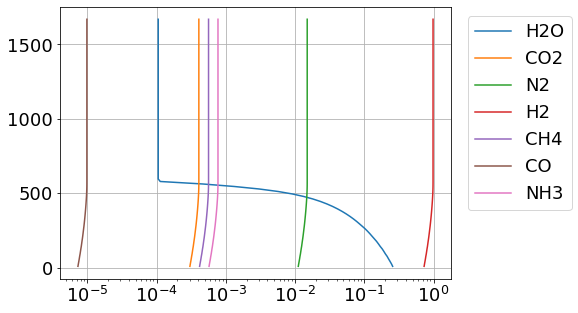

In [21]:
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(1,1,figsize=[7,5])
fig.patch.set_facecolor("w")

for i in range(len(c.species_names)):
    ax.plot(c.f_i[:,i],c.z/1e5,label=c.species_names[i])

ax.grid()
ax.legend(ncol=1,bbox_to_anchor=(1.02,1.0),loc='upper left')

ax.set_xscale('log')

plt.show()